In [ ]:
!pip install pandas numpy tqdm absl-py mtcnn torch torchvision scikit-learn timm matplotlib lmdb lz4 pillow torcheval tensorflow

# Load libraries

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from absl import flags, app
import json

from mtcnn import MTCNN

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import functools
import asyncio
import torchvision
from PIL import Image
from torchvision import transforms,datasets
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import timm
from torch import nn
from torcheval.metrics import MulticlassConfusionMatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

import lmdb
import pickle
from concurrent.futures import ThreadPoolExecutor
import warnings
from functools import partial
import io
import psutil
import lz4.frame

2024-12-01 01:14:38.860094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733015679.286209   25274 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733015679.328458   25274 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 01:14:39.769713: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load classes

In [8]:
class VidFramesDataset(Dataset):
    def __init__(self, sequence_len, final_celeb_df, transform=None, cache_dir='./dataset_cache2', initial_map_size_gb=100):
        self.sequence_len = sequence_len
        self.transform = transform
        self.base_dir = f"{os.getcwd()}/CELEB-DF-2"
        self.video_frame_dirs = [d for d in os.listdir(self.base_dir) if not d.startswith('.')]
        self.final_celeb_df = final_celeb_df
        self.cache_dir = cache_dir
        os.makedirs(cache_dir, exist_ok=True)

        # Initialize LMDB environment with an initial smaller map_size
        self.env = lmdb.open(
            os.path.join(cache_dir, 'frames_cache'),
            map_size=initial_map_size_gb * 1024 * 1024 * 1024 * 100
        )
        self.frame_paths = self._preload_frame_paths()

        self.labels = {video_dir: self.final_celeb_df[self.final_celeb_df.file_name == video_dir].real.values[0] for video_dir in self.video_frame_dirs if not self.final_celeb_df[self.final_celeb_df.file_name == video_dir].empty}
        if not os.path.exists(os.path.join(cache_dir, 'cached.txt')):
            self._cache_frames()
            with open(os.path.join(cache_dir, 'cached.txt'), 'w') as f:
                f.write('cached')

    def _preload_frame_paths(self):
        paths = {}
        for video_dir in self.video_frame_dirs:
            video_path = os.path.join(self.base_dir, video_dir)
            frame_paths = sorted(glob(os.path.join(video_path, 'frame_*.png')))[:self.sequence_len]
            paths[video_dir] = frame_paths
        return paths

    def _load_and_process_frame(self, frame_path):
        try:
            frame = torchvision.io.read_image(frame_path).float()
            if self.transform:
                frame = self.transform(frame)
            return frame
        except Exception as e:
            warnings.warn(f"Error loading frame {frame_path}: {str(e)}")
            return torch.zeros((3, 299, 299))

    def _cache_frames(self):
        print("Caching frames to LMDB with compression...")
        chunk_size = 100

        def process_video(video_dir):
            frames = torch.zeros((self.sequence_len, 3, 299, 299))
            frame_paths = self.frame_paths[video_dir]
            for i, frame_path in enumerate(frame_paths[:self.sequence_len]):
                frames[i] = self._load_and_process_frame(frame_path)
            # Delete frame files after processing
            video_path = os.path.join(self.base_dir, video_dir)
            for frame_file in frame_paths:
                os.remove(frame_file)  # Delete the frame file
            print(f"Deleted frames in: {video_path}")
            return video_dir, frames

        for i in tqdm(range(0, len(self.video_frame_dirs), chunk_size)):
            chunk = self.video_frame_dirs[i:i + chunk_size]
            with ThreadPoolExecutor(max_workers=min(os.cpu_count(), 4)) as executor:
                futures = [executor.submit(process_video, video_dir) for video_dir in chunk]
                with self.env.begin(write=True) as txn:
                    for future in futures:
                        result = future.result()
                        if result:
                            video_dir, frames = result
                            txn.put(video_dir.encode(), lz4.frame.compress(pickle.dumps(frames)))

            # Dynamically increase map size if needed
            if i % 500 == 0:
                self.env.set_mapsize(self.env.info()['map_size'] + 1024 * 1024 * 1024 * 20)  # Increase by 20GB
                
    def __len__(self):
        return len(self.video_frame_dirs)
        
    def __getitem__(self, idx):
        video_dir = self.video_frame_dirs[idx]
        with self.env.begin(write=False) as txn:
            frames_data = txn.get(video_dir.encode())
            if frames_data:
                video_frames = pickle.loads(lz4.frame.decompress(frames_data))[:self.sequence_len]
            else:
                frame_paths = self.frame_paths[video_dir]
                video_frames = torch.stack([self._load_and_process_frame(f) for f in frame_paths[:self.sequence_len]])
        return self.labels.get(video_dir, -1), video_frames


class DeepFakeDetector(nn.Module):
    def __init__(self, hidden_size=512, num_layers=2, num_classes=1, bidirectional=True, attention_bool=False):
        super(DeepFakeDetector, self).__init__()
        
        # Load pre-trained XceptionNet from timm
        self.feature_extractor = timm.create_model('xception', pretrained=True, num_classes=0)  # num_classes=0 removes the classification head
        self.feature_extractor.eval()  # Set to evaluation mode
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = False  # Freeze XceptionNet
        
        # Define LSTM
        self.lstm = nn.LSTM(input_size=2048,  # XceptionNet's output feature size
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=bidirectional)

        # Attention layer to compute attention weights over the LSTM output
        self.attention = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, 1)
        self.attention_bool = attention_bool
        
        # Define fully connected layer
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch, num_frames, 3, 299, 299)
        Returns:
            out: Tensor of shape (batch, 1)
        """
        batch_size, num_frames, C, H, W = x.size()
        # Merge batch and time dimensions for feature extraction
        x = x.view(batch_size * num_frames, C, H, W)  # (batch*num_frames, 3, 299, 299)
        
        with torch.no_grad():
            features = self.feature_extractor(x)  # (batch*num_frames, 2048)
        
        # Reshape back to (batch, num_frames, feature_size)
        features = features.view(batch_size, num_frames, -1)  # (batch, num_frames, 2048)
        
        # Pass through LSTM
        lstm_out, (hn, cn) = self.lstm(features)  # lstm_out: (batch, num_frames, hidden_size*2)

        if self.attention_bool:
            # Attention mechanism
            attention_scores = self.attention(lstm_out)  # (batch, num_frames, 1)
            attention_weights = F.softmax(attention_scores, dim=1)  # Normalize attention scores over timesteps
            
            # Weighted sum of LSTM outputs (context vector)
            context = torch.sum(attention_weights * lstm_out, dim=1)  # (batch, hidden_size*2)
            
            # Pass the context vector through the fully connected layer
            out = self.fc(context)  # (batch, num_classes)
            
            return out.squeeze()  # (batch)
        
        # Use the last timestep's output
        # Alternatively, you can use pooling over time
        if self.lstm.bidirectional:
            final_feature = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1)  # (batch, hidden_size*2)
        else:
            final_feature = hn[-1,:,:]  # (batch, hidden_size)
        
        out = self.fc(final_feature)  # (batch, num_classes)
        # out = self.sigmoid(out)  # (batch, num_classes)
        
        return out.squeeze()  # (batch)

# Initialize Training, Validation, and Testing Data

In [9]:
final_celeb_df = pd.read_csv('./final_celeb_df2')

transform = transforms.Compose([
transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

# Create a Dataset object
dataset = VidFramesDataset(40,final_celeb_df=final_celeb_df,transform=transform)

labels = []
indices = []

for idx in tqdm(range(len(dataset))):
    label, frames = dataset[idx]
    if label != -1:
        labels.append(dataset[idx][0])
        indices.append(idx)

train_val_indices, test_indices, train_val_labels, test_labels = train_test_split(
    indices,
    labels,
    test_size=0.2,
    stratify = labels
)

train_indices, val_indices, _,_ = train_test_split(
    train_val_indices,
    train_val_labels,
    test_size=0.25,
    stratify=train_val_labels
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

batch_size = 8
num_workers = 0

prefetch_factor = None

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers,pin_memory=True,prefetch_factor=prefetch_factor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers,pin_memory=True,prefetch_factor=prefetch_factor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers,pin_memory=True,prefetch_factor=prefetch_factor)

100%|██████████| 6524/6524 [59:29<00:00,  1.83it/s]  


# Set CUDA Device

In [10]:
device = torch.device("cuda:0")

# Testing and Evaluating Normal LSTM for 10 Epochs

In [ ]:
model = DeepFakeDetector(hidden_size=512, num_layers=2, num_classes=1, bidirectional=False)
model.load_state_dict(torch.load("./runs/run2/model_final.pth", weights_only=True))
model = model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []  # Store probabilities for AUC-ROC
    results = []
    
    for labels, videos in tqdm(test_loader):
        videos = videos.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(videos)  # Raw logits or probabilities
        
        probabilities = outputs  # Convert logits to probabilities
        predicted = (outputs >= 0.5).long()  # Threshold at 0.5
        results.append(predicted.tolist())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        if probabilities.dim() > 0:
            all_probabilities.extend(probabilities.cpu().numpy())
        else:
            all_probabilities.append(probabilities.cpu().item())
            
        if predicted.dim() > 0:
            all_predictions.extend(predicted.cpu().numpy())
        else:
            all_predictions.append(predicted.cpu().item())

    train_accuracy = correct / total
    print(f'Test Accuracy: {train_accuracy * 100:.2f}%')

## Confusion Matrix

Confusion Matrix:
[[1122    5]
 [  80   98]]


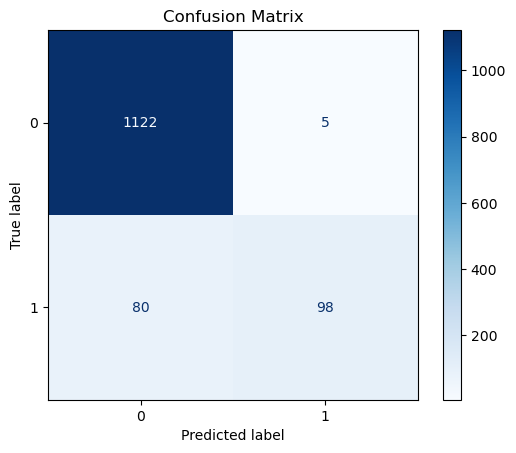

In [23]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Change labels if needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## F1 Score

In [24]:
# Compute F1 score
f1 = f1_score(all_labels, all_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.6975


## AUC-ROC

AUC-ROC: 0.9420


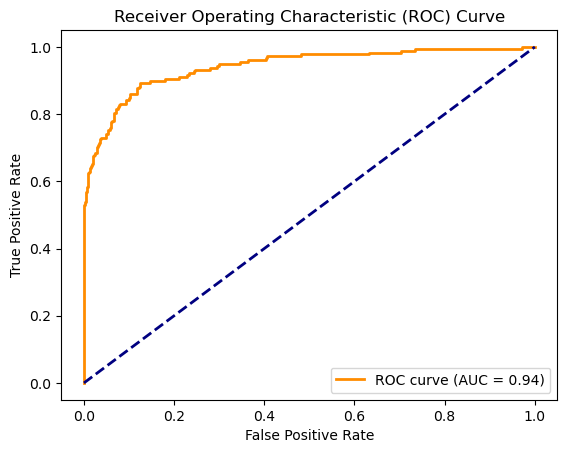

In [25]:
# Compute AUC-ROC and plot the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Testing and Evaluating Bi-LSTM for 10 Epochs

In [ ]:
model = DeepFakeDetector(hidden_size=512, num_layers=2, num_classes=1, bidirectional=True)
model.load_state_dict(torch.load("./runs/run3/model_final.pth", weights_only=True))
model = model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []  # Store probabilities for AUC-ROC
    results = []
    
    for labels, videos in tqdm(test_loader):
        videos = videos.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(videos)  # Raw logits or probabilities
        
        probabilities = outputs  # Convert logits to probabilities
        predicted = (outputs >= 0.5).long()  # Threshold at 0.5
        results.append(predicted.tolist())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        if probabilities.dim() > 0:
            all_probabilities.extend(probabilities.cpu().numpy())
        else:
            all_probabilities.append(probabilities.cpu().item())
            
        if predicted.dim() > 0:
            all_predictions.extend(predicted.cpu().numpy())
        else:
            all_predictions.append(predicted.cpu().item())

    train_accuracy = correct / total
    print(f'Test Accuracy: {train_accuracy * 100:.2f}%')

## Confusion Matrix

Confusion Matrix:
[[1120    7]
 [  60  118]]


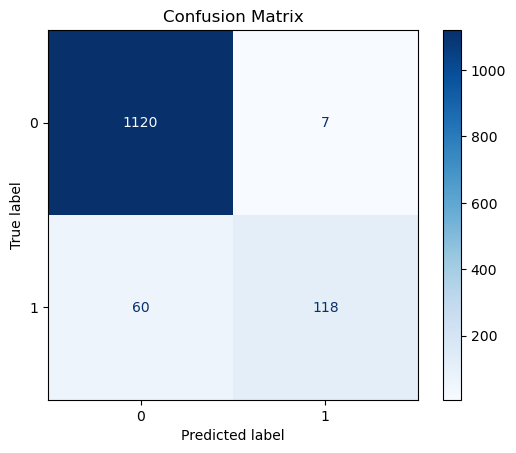

In [27]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Change labels if needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## F1 Score

In [28]:
# Compute F1 score
f1 = f1_score(all_labels, all_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.7789


## AUC-ROC

AUC-ROC: 0.9612


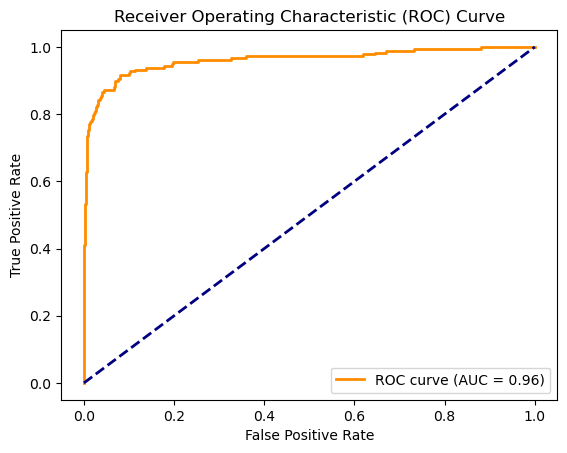

In [29]:
# Compute AUC-ROC and plot the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Testing and Evaluating Normal LSTM for 20 Epochs

In [ ]:
model = DeepFakeDetector(hidden_size=512, num_layers=2, num_classes=1, bidirectional=False)
model.load_state_dict(torch.load("./runs/run4/model_final.pth", weights_only=True))
model = model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []  # Store probabilities for AUC-ROC
    results = []
    
    for labels, videos in tqdm(test_loader):
        videos = videos.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(videos)  # Raw logits or probabilities
        
        probabilities = outputs  # Convert logits to probabilities
        predicted = (outputs >= 0.5).long()  # Threshold at 0.5
        results.append(predicted.tolist())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        if probabilities.dim() > 0:
            all_probabilities.extend(probabilities.cpu().numpy())
        else:
            all_probabilities.append(probabilities.cpu().item())
            
        if predicted.dim() > 0:
            all_predictions.extend(predicted.cpu().numpy())
        else:
            all_predictions.append(predicted.cpu().item())

    train_accuracy = correct / total
    print(f'Test Accuracy: {train_accuracy * 100:.2f}%')

## Confusion Matrix

Confusion Matrix:
[[1116   11]
 [  36  142]]


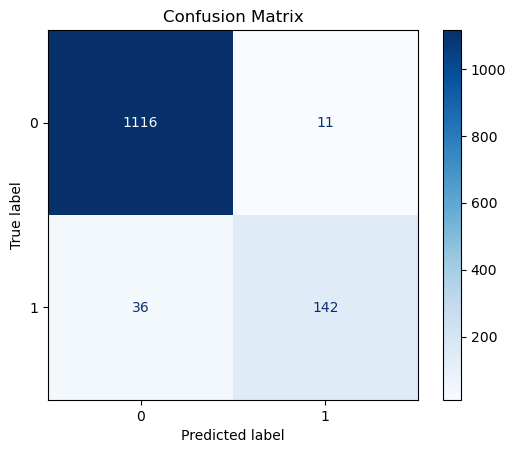

In [31]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Change labels if needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## F1 Score

In [32]:
# Compute F1 score
f1 = f1_score(all_labels, all_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.8580


## AUC-ROC

AUC-ROC: 0.9693


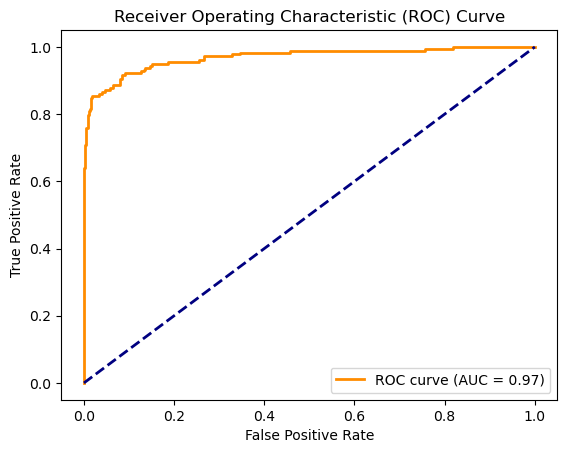

In [33]:
# Compute AUC-ROC and plot the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Testing and Evaluating Bi-LSTM for 20 Epochs

In [ ]:
model = DeepFakeDetector(hidden_size=512, num_layers=2, num_classes=1, bidirectional=True)
model.load_state_dict(torch.load("./runs/run5/model_final.pth", weights_only=True))
model = model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []  # Store probabilities for AUC-ROC
    results = []
    
    for labels, videos in tqdm(test_loader):
        videos = videos.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(videos)  # Raw logits or probabilities
        
        probabilities = outputs  # Convert logits to probabilities
        predicted = (outputs >= 0.5).long()  # Threshold at 0.5
        results.append(predicted.tolist())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        if probabilities.dim() > 0:
            all_probabilities.extend(probabilities.cpu().numpy())
        else:
            all_probabilities.append(probabilities.cpu().item())
            
        if predicted.dim() > 0:
            all_predictions.extend(predicted.cpu().numpy())
        else:
            all_predictions.append(predicted.cpu().item())

    train_accuracy = correct / total
    print(f'Test Accuracy: {train_accuracy * 100:.2f}%')

## Confusion Matrix

Confusion Matrix:
[[1109   18]
 [  26  152]]


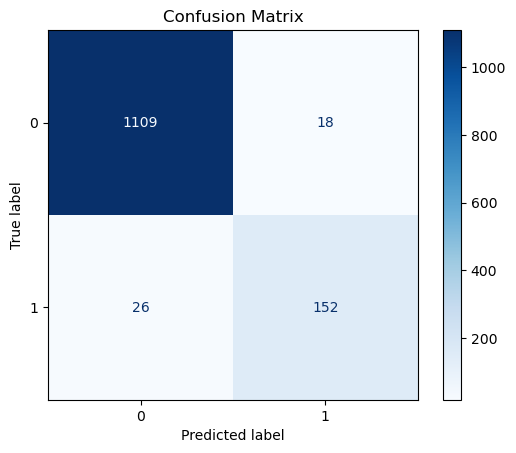

In [35]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Change labels if needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## F1 Score

In [36]:
# Compute F1 score
f1 = f1_score(all_labels, all_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.8736


## AUC-ROC

AUC-ROC: 0.9581


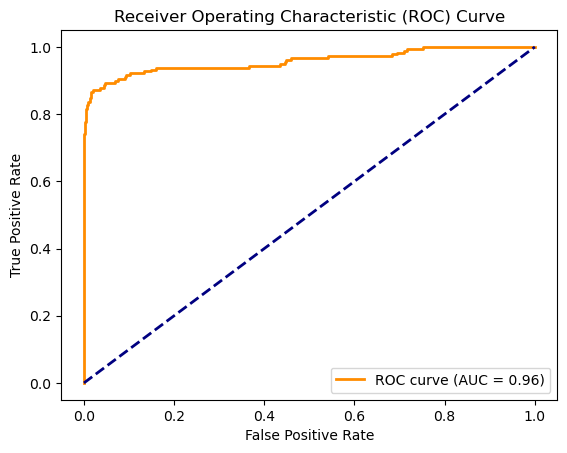

In [37]:
# Compute AUC-ROC and plot the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [11]:
model = DeepFakeDetector(hidden_size=512, num_layers=2, num_classes=1, bidirectional=True)
model.load_state_dict(torch.load("./runs/run9/model_final.pth", weights_only=True))
model = model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []  # Store probabilities for AUC-ROC
    results = []
    
    for labels, videos in tqdm(test_loader):
        videos = videos.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(videos)  # Raw logits or probabilities

        probabilities = outputs  # Convert logits to probabilities
        predicted = (probabilities >= 0.5).long()  # Threshold at 0.5
        results.append(predicted.tolist())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        if probabilities.dim() > 0:
            all_probabilities.extend(probabilities.cpu().numpy())
        else:
            all_probabilities.append(probabilities.cpu().item())
            
        if predicted.dim() > 0:
            all_predictions.extend(predicted.cpu().numpy())
        else:
            all_predictions.append(predicted.cpu().item())

    train_accuracy = correct / total
    print(f'Test Accuracy: {train_accuracy * 100:.2f}%')

/opt/conda/lib/python3.11/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
100%|██████████| 164/164 [06:06<00:00,  2.24s/it]

Test Accuracy: 88.35%


## Confusion Matrix

Confusion Matrix:
[[1127    0]
 [ 152   26]]


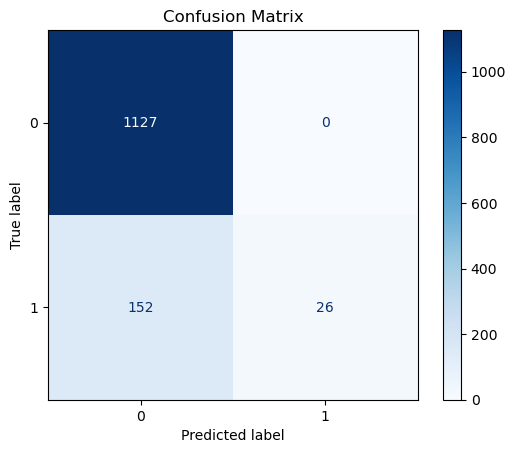

In [12]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Change labels if needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## F1 Score

In [13]:
# Compute F1 score
f1 = f1_score(all_labels, all_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.2549


## AUC-ROC

AUC-ROC: 0.9462


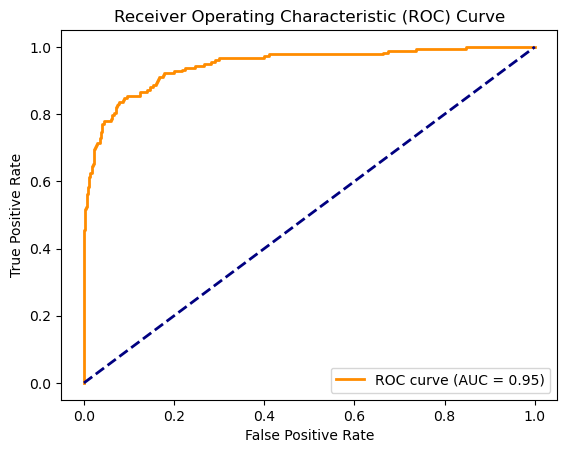

In [14]:
# Compute AUC-ROC and plot the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Testing and Evaluating Normal LSTM for 20 Epochs (with Focal Loss and Attention)

In [ ]:
model = DeepFakeDetector(hidden_size=512, num_layers=2, num_classes=1, bidirectional=False, attention_bool=True)
model.load_state_dict(torch.load("./runs/run10/model_final.pth", weights_only=True))
model = model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []  # Store probabilities for AUC-ROC
    results = []
    
    for labels, videos in tqdm(test_loader):
        videos = videos.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(videos)  # Raw logits or probabilities

        probabilities = outputs  # Convert logits to probabilities
        predicted = (probabilities >= 0.5).long()  # Threshold at 0.5
        results.append(predicted.tolist())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        if probabilities.dim() > 0:
            all_probabilities.extend(probabilities.cpu().numpy())
        else:
            all_probabilities.append(probabilities.cpu().item())
            
        if predicted.dim() > 0:
            all_predictions.extend(predicted.cpu().numpy())
        else:
            all_predictions.append(predicted.cpu().item())

    train_accuracy = correct / total
    print(f'Test Accuracy: {train_accuracy * 100:.2f}%')

## Confusion Matrix

Confusion Matrix:
[[1105   22]
 [  42  136]]


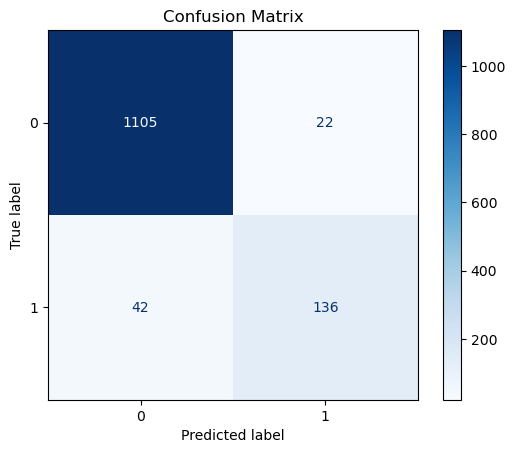

In [15]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Change labels if needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## F1 Score

In [16]:
# Compute F1 score
f1 = f1_score(all_labels, all_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.8095


## AUC-ROC

AUC-ROC: 0.9624


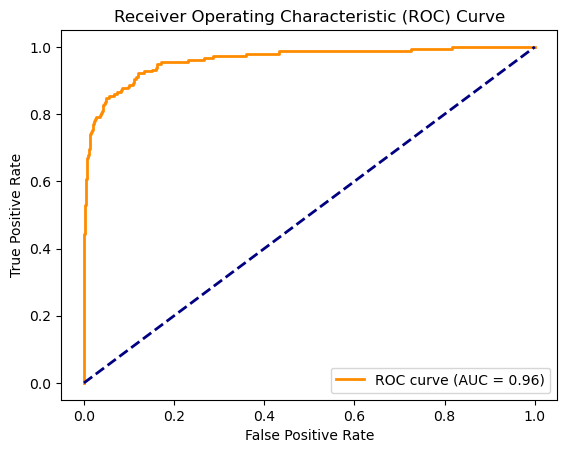

In [17]:
# Compute AUC-ROC and plot the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Testing and Evaluating Bi-LSTM for 20 Epochs (with Focal Loss and Attention)

In [ ]:
model = DeepFakeDetector(hidden_size=512, num_layers=2, num_classes=1, bidirectional=True, attention_bool=True)
model.load_state_dict(torch.load("./runs/run11/model_final.pth", weights_only=True))
model = model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []  # Store probabilities for AUC-ROC
    results = []
    
    for labels, videos in tqdm(test_loader):
        videos = videos.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(videos)  # Raw logits or probabilities

        probabilities = outputs  # Convert logits to probabilities
        predicted = (probabilities >= 0.5).long()  # Threshold at 0.5
        results.append(predicted.tolist())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        if probabilities.dim() > 0:
            all_probabilities.extend(probabilities.cpu().numpy())
        else:
            all_probabilities.append(probabilities.cpu().item())
            
        if predicted.dim() > 0:
            all_predictions.extend(predicted.cpu().numpy())
        else:
            all_predictions.append(predicted.cpu().item())

    train_accuracy = correct / total
    print(f'Test Accuracy: {train_accuracy * 100:.2f}%')

## Confusion Matrix

Confusion Matrix:
[[1109   18]
 [  37  141]]


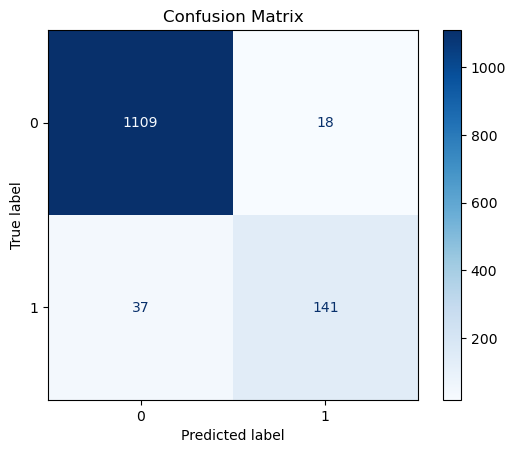

In [6]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Change labels if needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## F1 Score

In [7]:
# Compute F1 score
f1 = f1_score(all_labels, all_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.8368


## AUC-ROC

AUC-ROC: 0.9746


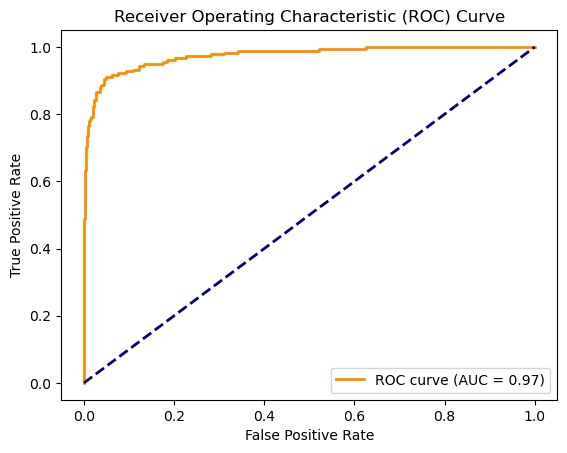

In [8]:
# Compute AUC-ROC and plot the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Testing and Evaluating Normal LSTM for 20 Epochs (with only Focal Loss)

In [ ]:
model = DeepFakeDetector(hidden_size=512, num_layers=2, num_classes=1, bidirectional=False, attention_bool=False)
model.load_state_dict(torch.load("./runs/run12/model_final.pth", weights_only=True))
model = model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []  # Store probabilities for AUC-ROC
    results = []
    
    for labels, videos in tqdm(test_loader):
        videos = videos.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(videos)  # Raw logits or probabilities

        probabilities = outputs  # Convert logits to probabilities
        predicted = (probabilities >= 0.5).long()  # Threshold at 0.5
        results.append(predicted.tolist())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        if probabilities.dim() > 0:
            all_probabilities.extend(probabilities.cpu().numpy())
        else:
            all_probabilities.append(probabilities.cpu().item())
            
        if predicted.dim() > 0:
            all_predictions.extend(predicted.cpu().numpy())
        else:
            all_predictions.append(predicted.cpu().item())

    train_accuracy = correct / total
    print(f'Test Accuracy: {train_accuracy * 100:.2f}%')

## Confusion Matrix

Confusion Matrix:
[[1123    4]
 [  45  133]]


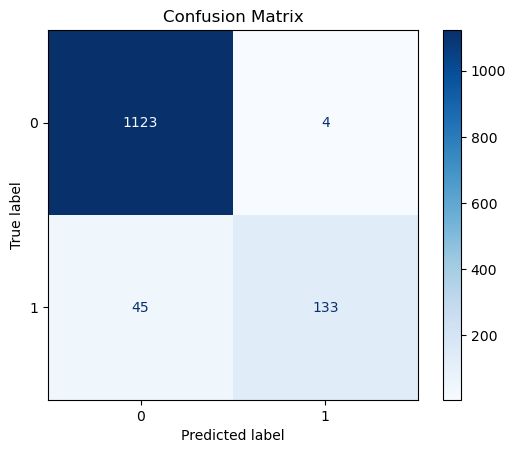

In [10]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Change labels if needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## F1 Score

In [11]:
# Compute F1 score
f1 = f1_score(all_labels, all_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.8444


## AUC-ROC

AUC-ROC: 0.9689


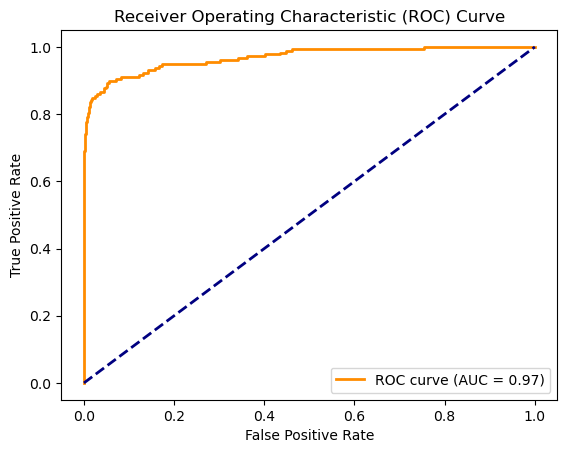

In [12]:
# Compute AUC-ROC and plot the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Testing and Evaluating Bi-LSTM for 20 Epochs (with only Focal Loss)

In [ ]:
model = DeepFakeDetector(hidden_size=512, num_layers=2, num_classes=1, bidirectional=True, attention_bool=False)
model.load_state_dict(torch.load("./runs/run13/model_final.pth", weights_only=True))
model = model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []  # Store probabilities for AUC-ROC
    results = []
    
    for labels, videos in tqdm(test_loader):
        videos = videos.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(videos)  # Raw logits or probabilities

        probabilities = outputs  # Convert logits to probabilities
        predicted = (probabilities >= 0.5).long()  # Threshold at 0.5
        results.append(predicted.tolist())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        if probabilities.dim() > 0:
            all_probabilities.extend(probabilities.cpu().numpy())
        else:
            all_probabilities.append(probabilities.cpu().item())
            
        if predicted.dim() > 0:
            all_predictions.extend(predicted.cpu().numpy())
        else:
            all_predictions.append(predicted.cpu().item())

    train_accuracy = correct / total
    print(f'Test Accuracy: {train_accuracy * 100:.2f}%')

## Confusion Matrix

Confusion Matrix:
[[1112   15]
 [  35  143]]


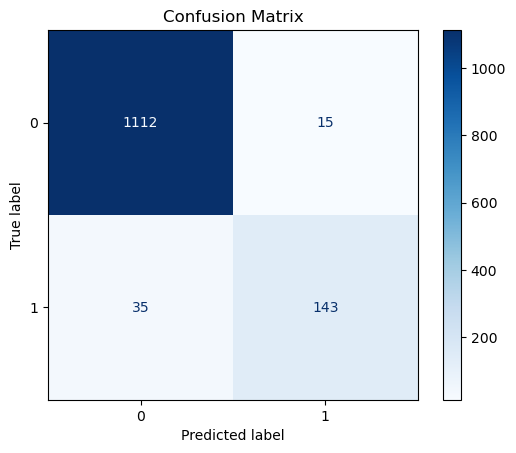

In [14]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Change labels if needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## F1 Score

In [15]:
# Compute F1 score
f1 = f1_score(all_labels, all_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.8512


## AUC-ROC

AUC-ROC: 0.9529


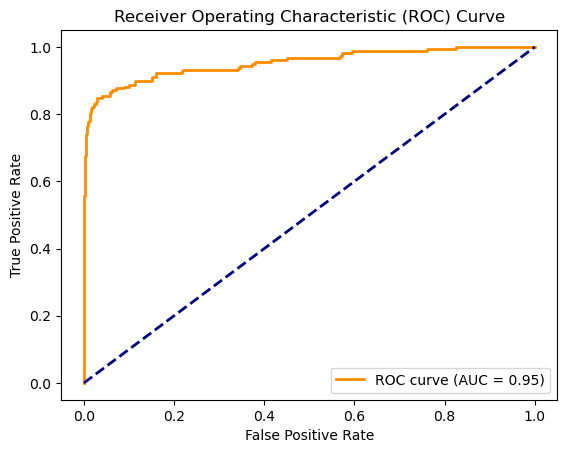

In [16]:
# Compute AUC-ROC and plot the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Testing and Evaluating Normal LSTM for 20 Epochs and Sequence Length 30 (with Focal Loss and Attention)

In [ ]:
model = DeepFakeDetector(hidden_size=512, num_layers=2, num_classes=1, bidirectional=False, attention_bool=True)
model.load_state_dict(torch.load("./runs/20epochs-normal_lstm-fixed_focal-attention-30seq/model_final.pth", weights_only=True))
model = model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []  # Store probabilities for AUC-ROC
    results = []
    
    for labels, videos in tqdm(test_loader):
        videos = videos.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(videos)  # Raw logits or probabilities

        probabilities = outputs  # Convert logits to probabilities
        predicted = (probabilities >= 0.5).long()  # Threshold at 0.5
        results.append(predicted.tolist())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        if probabilities.dim() > 0:
            all_probabilities.extend(probabilities.cpu().numpy())
        else:
            all_probabilities.append(probabilities.cpu().item())
            
        if predicted.dim() > 0:
            all_predictions.extend(predicted.cpu().numpy())
        else:
            all_predictions.append(predicted.cpu().item())

    train_accuracy = correct / total
    print(f'Test Accuracy: {train_accuracy * 100:.2f}%')

## Confusion Matrix

Confusion Matrix:
[[1028   64]
 [  35  139]]


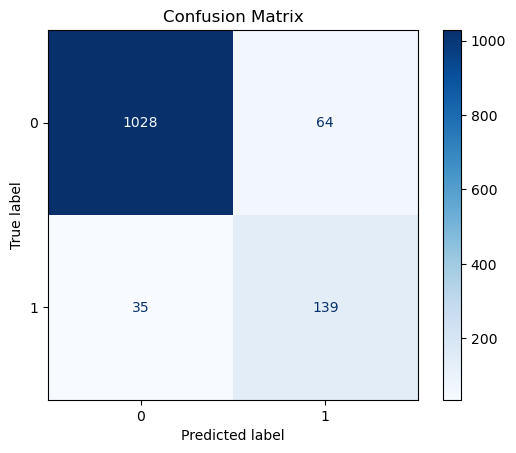

In [12]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Change labels if needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## F1 Score

In [13]:
# Compute F1 score
f1 = f1_score(all_labels, all_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.7374


## AUC-ROC

AUC-ROC: 0.9536


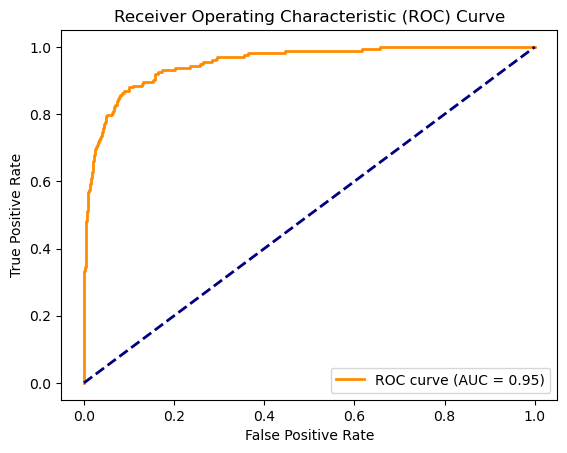

In [14]:
# Compute AUC-ROC and plot the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Testing and Evaluating Bi-LSTM for 20 Epochs and Sequence Length 30 (with Focal Loss and Attention)

In [ ]:
model = DeepFakeDetector(hidden_size=512, num_layers=2, num_classes=1, bidirectional=True, attention_bool=True)
model.load_state_dict(torch.load("./runs/20epochs-bi_lstm-fixed_focal-attention-30seq/model_final.pth", weights_only=True))
model = model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []  # Store probabilities for AUC-ROC
    results = []
    
    for labels, videos in tqdm(test_loader):
        print(labels)
        videos = videos.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(videos)  # Raw logits or probabilities

        probabilities = outputs  # Convert logits to probabilities
        predicted = (probabilities >= 0.5).long()  # Threshold at 0.5
        results.append(predicted.tolist())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        if probabilities.dim() > 0:
            all_probabilities.extend(probabilities.cpu().numpy())
        else:
            all_probabilities.append(probabilities.cpu().item())
            
        if predicted.dim() > 0:
            all_predictions.extend(predicted.cpu().numpy())
        else:
            all_predictions.append(predicted.cpu().item())

    train_accuracy = correct / total
    print(f'Test Accuracy: {train_accuracy * 100:.2f}%')

## Confusion Matrix

Confusion Matrix:
[[1075   17]
 [  58  116]]
[0]


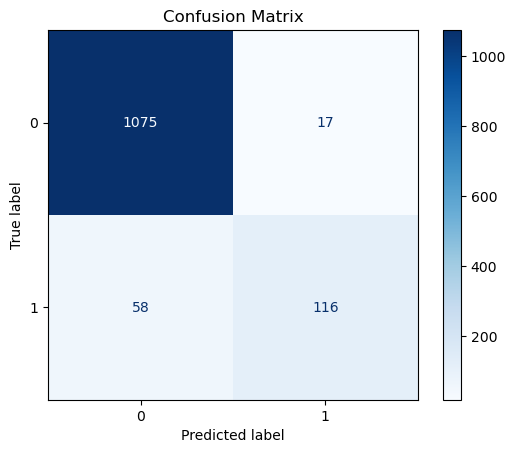

In [16]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

print(np.unique(labels.tolist()))

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Change labels if needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## F1 Score

In [17]:
# Compute F1 score
f1 = f1_score(all_labels, all_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.7557


## AUC-ROC

AUC-ROC: 0.9665


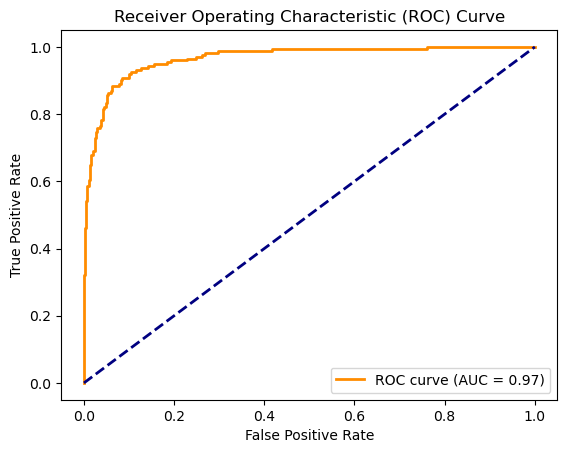

In [18]:
# Compute AUC-ROC and plot the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Testing and Evaluating Normal LSTM for 20 Epochs and Sequence Length 30 (with Focal Loss)

In [ ]:
model = DeepFakeDetector(hidden_size=512, num_layers=2, num_classes=1, bidirectional=False, attention_bool=False)
model.load_state_dict(torch.load("./runs/20epochs-normal_lstm-fixed_focal-30seq/model_final.pth", weights_only=True))
model = model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []  # Store probabilities for AUC-ROC
    results = []
    
    for labels, videos in tqdm(test_loader):
        videos = videos.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(videos)  # Raw logits or probabilities

        probabilities = outputs  # Convert logits to probabilities
        predicted = (probabilities >= 0.5).long()  # Threshold at 0.5
        results.append(predicted.tolist())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        if probabilities.dim() > 0:
            all_probabilities.extend(probabilities.cpu().numpy())
        else:
            all_probabilities.append(probabilities.cpu().item())
            
        if predicted.dim() > 0:
            all_predictions.extend(predicted.cpu().numpy())
        else:
            all_predictions.append(predicted.cpu().item())

    train_accuracy = correct / total
    print(f'Test Accuracy: {train_accuracy * 100:.2f}%')

## Confusion Matrix

Confusion Matrix:
[[1088    4]
 [ 116   58]]


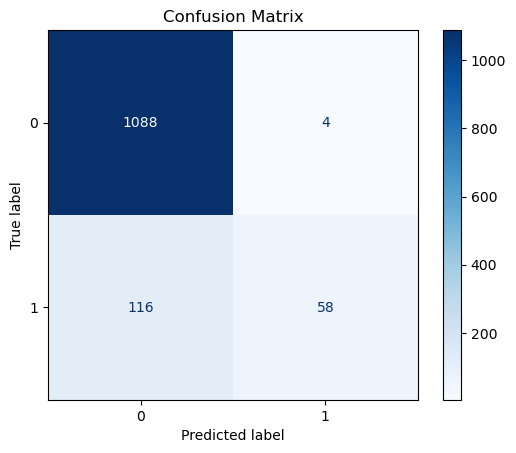

In [20]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Change labels if needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## F1 Score

In [21]:
# Compute F1 score
f1 = f1_score(all_labels, all_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.4915


## AUC-ROC

AUC-ROC: 0.8459


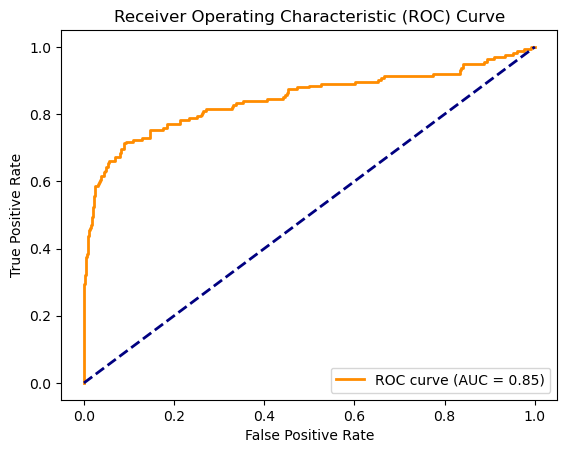

In [22]:
# Compute AUC-ROC and plot the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Testing and Evaluating Bi-LSTM for 20 Epochs and Sequence Length 30 (with Focal Loss)

In [ ]:
model = DeepFakeDetector(hidden_size=512, num_layers=2, num_classes=1, bidirectional=True, attention_bool=True)
model.load_state_dict(torch.load("./runs/20epochs-bi_lstm-fixed_focal-30seq/model_final.pth", weights_only=True))
model = model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []  # Store probabilities for AUC-ROC
    results = []
    
    for labels, videos in tqdm(test_loader):
        print(labels)
        videos = videos.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(videos)  # Raw logits or probabilities

        probabilities = outputs  # Convert logits to probabilities
        predicted = (probabilities >= 0.5).long()  # Threshold at 0.5
        results.append(predicted.tolist())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        if probabilities.dim() > 0:
            all_probabilities.extend(probabilities.cpu().numpy())
        else:
            all_probabilities.append(probabilities.cpu().item())
            
        if predicted.dim() > 0:
            all_predictions.extend(predicted.cpu().numpy())
        else:
            all_predictions.append(predicted.cpu().item())

    train_accuracy = correct / total
    print(f'Test Accuracy: {train_accuracy * 100:.2f}%')

## Confusion Matrix

Confusion Matrix:
[[893 199]
 [ 32 142]]
[0]


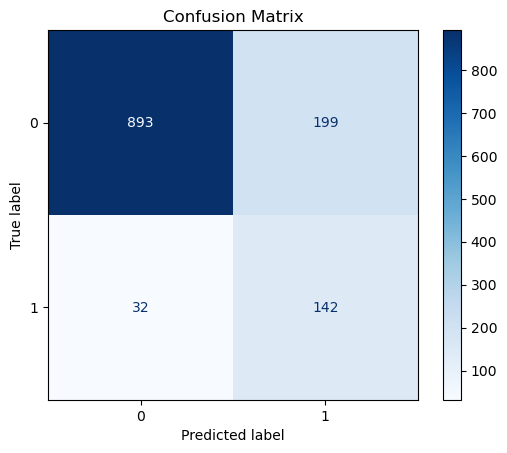

In [12]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

print(np.unique(labels.tolist()))

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Change labels if needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## F1 Score

In [13]:
# Compute F1 score
f1 = f1_score(all_labels, all_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.5515


## AUC-ROC

AUC-ROC: 0.8961


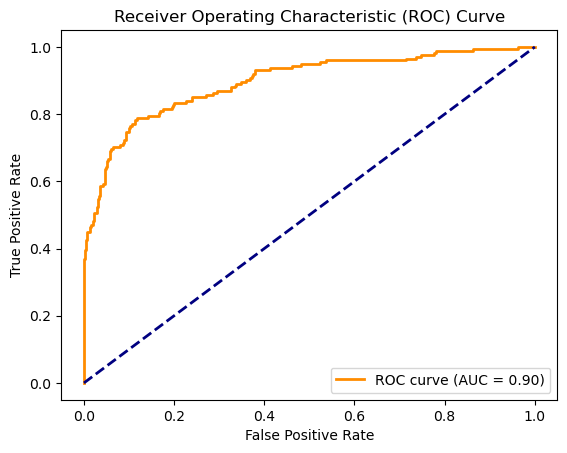

In [14]:
# Compute AUC-ROC and plot the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Testing and Evaluating Normal LSTM for 20 Epochs and Sequence Length 40 (with Focal Loss and Attention)

In [ ]:
model = DeepFakeDetector(hidden_size=512, num_layers=2, num_classes=1, bidirectional=False, attention_bool=True)
model.load_state_dict(torch.load("./runs/20epochs-normal_lstm-fixed_focal-attention-40seq/model_final.pth", weights_only=True))
model = model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []  # Store probabilities for AUC-ROC
    results = []
    
    for labels, videos in tqdm(test_loader):
        videos = videos.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(videos)  # Raw logits or probabilities

        probabilities = outputs  # Convert logits to probabilities
        predicted = (probabilities >= 0.5).long()  # Threshold at 0.5
        results.append(predicted.tolist())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        if probabilities.dim() > 0:
            all_probabilities.extend(probabilities.cpu().numpy())
        else:
            all_probabilities.append(probabilities.cpu().item())
            
        if predicted.dim() > 0:
            all_predictions.extend(predicted.cpu().numpy())
        else:
            all_predictions.append(predicted.cpu().item())

    train_accuracy = correct / total
    print(f'Test Accuracy: {train_accuracy * 100:.2f}%')

## Confusion Matrix

Confusion Matrix:
[[1072   20]
 [  55  119]]


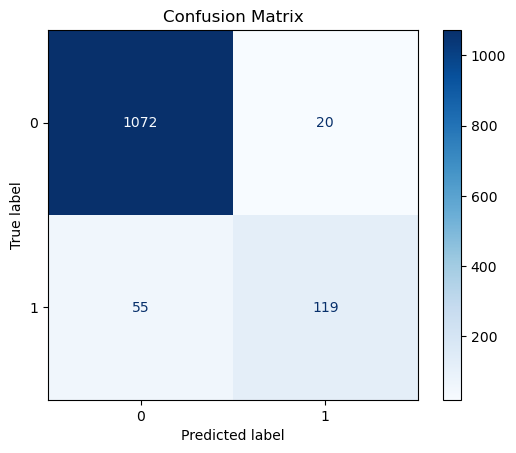

In [6]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Change labels if needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## F1 Score

In [7]:
# Compute F1 score
f1 = f1_score(all_labels, all_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.7604


## AUC-ROC

AUC-ROC: 0.9574


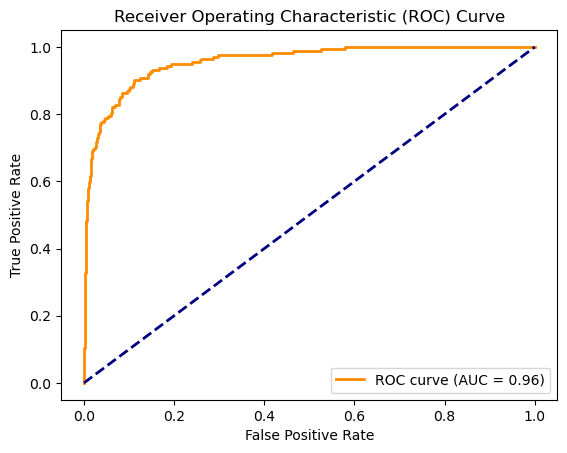

In [8]:
# Compute AUC-ROC and plot the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Testing and Evaluating Bi-LSTM for 20 Epochs and Sequence Length 40 (with Focal Loss and Attention)

In [ ]:
model = DeepFakeDetector(hidden_size=512, num_layers=2, num_classes=1, bidirectional=True, attention_bool=True)
model.load_state_dict(torch.load("./runs/20epochs-bi_lstm-fixed_focal-attention-40seq/model_final.pth", weights_only=True))
model = model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []  # Store probabilities for AUC-ROC
    results = []
    
    for labels, videos in tqdm(test_loader):
        print(labels)
        videos = videos.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(videos)  # Raw logits or probabilities

        probabilities = outputs  # Convert logits to probabilities
        predicted = (probabilities >= 0.5).long()  # Threshold at 0.5
        results.append(predicted.tolist())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        if probabilities.dim() > 0:
            all_probabilities.extend(probabilities.cpu().numpy())
        else:
            all_probabilities.append(probabilities.cpu().item())
            
        if predicted.dim() > 0:
            all_predictions.extend(predicted.cpu().numpy())
        else:
            all_predictions.append(predicted.cpu().item())

    train_accuracy = correct / total
    print(f'Test Accuracy: {train_accuracy * 100:.2f}%')

## Confusion Matrix

Confusion Matrix:
[[1073   19]
 [  66  108]]
[0]


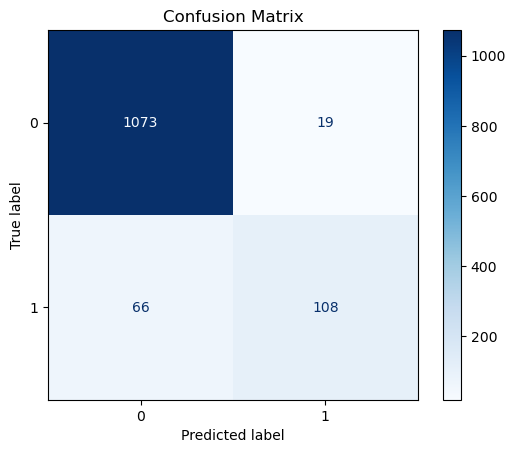

In [6]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

print(np.unique(labels.tolist()))

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Change labels if needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## F1 Score

In [7]:
# Compute F1 score
f1 = f1_score(all_labels, all_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.7176


## AUC-ROC

AUC-ROC: 0.9534


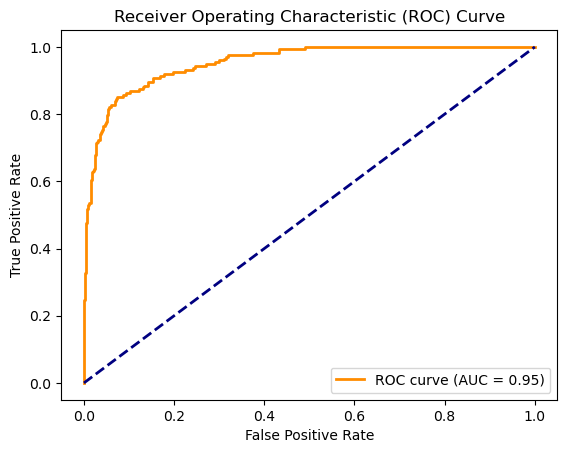

In [8]:
# Compute AUC-ROC and plot the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Testing and Evaluating Normal LSTM for 20 Epochs and Sequence Length 40 (with Focal Loss)

In [ ]:
model = DeepFakeDetector(hidden_size=512, num_layers=2, num_classes=1, bidirectional=False, attention_bool=False)
model.load_state_dict(torch.load("./runs/20epochs-normal_lstm-fixed_focal-40seq/model_final.pth", weights_only=True))
model = model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []  # Store probabilities for AUC-ROC
    results = []
    
    for labels, videos in tqdm(test_loader):
        videos = videos.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(videos)  # Raw logits or probabilities

        probabilities = outputs  # Convert logits to probabilities
        predicted = (probabilities >= 0.5).long()  # Threshold at 0.5
        results.append(predicted.tolist())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        if probabilities.dim() > 0:
            all_probabilities.extend(probabilities.cpu().numpy())
        else:
            all_probabilities.append(probabilities.cpu().item())
            
        if predicted.dim() > 0:
            all_predictions.extend(predicted.cpu().numpy())
        else:
            all_predictions.append(predicted.cpu().item())

    train_accuracy = correct / total
    print(f'Test Accuracy: {train_accuracy * 100:.2f}%')

## Confusion Matrix

Confusion Matrix:
[[1073   19]
 [  61  113]]


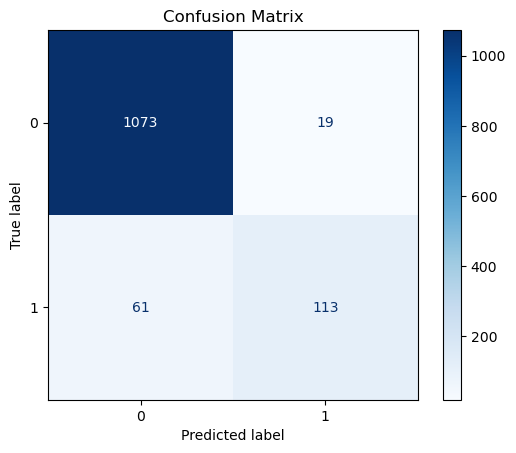

In [10]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Change labels if needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## F1 Score

In [11]:
# Compute F1 score
f1 = f1_score(all_labels, all_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.7386


## AUC-ROC

AUC-ROC: 0.9150


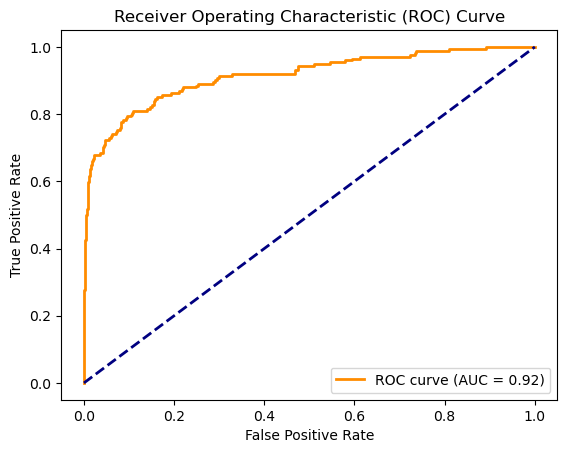

In [12]:
# Compute AUC-ROC and plot the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Testing and Evaluating Bi-LSTM for 20 Epochs and Sequence Length 40 (with Focal Loss)

In [ ]:
model = DeepFakeDetector(hidden_size=512, num_layers=2, num_classes=1, bidirectional=True, attention_bool=True)
model.load_state_dict(torch.load("./runs/20epochs-bi_lstm-fixed_focal-40seq/model_final.pth", weights_only=True))
model = model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []  # Store probabilities for AUC-ROC
    results = []
    
    for labels, videos in tqdm(test_loader):
        print(labels)
        videos = videos.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(videos)  # Raw logits or probabilities

        probabilities = outputs  # Convert logits to probabilities
        predicted = (probabilities >= 0.5).long()  # Threshold at 0.5
        results.append(predicted.tolist())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        if probabilities.dim() > 0:
            all_probabilities.extend(probabilities.cpu().numpy())
        else:
            all_probabilities.append(probabilities.cpu().item())
            
        if predicted.dim() > 0:
            all_predictions.extend(predicted.cpu().numpy())
        else:
            all_predictions.append(predicted.cpu().item())

    train_accuracy = correct / total
    print(f'Test Accuracy: {train_accuracy * 100:.2f}%')

## Confusion Matrix

Confusion Matrix:
[[1051   41]
 [  57  117]]
[0]


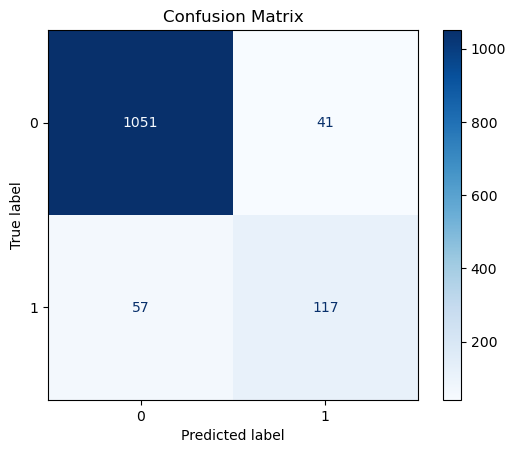

In [6]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

print(np.unique(labels.tolist()))

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Change labels if needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## F1 Score

In [7]:
# Compute F1 score
f1 = f1_score(all_labels, all_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.7048


## AUC-ROC

AUC-ROC: 0.8817


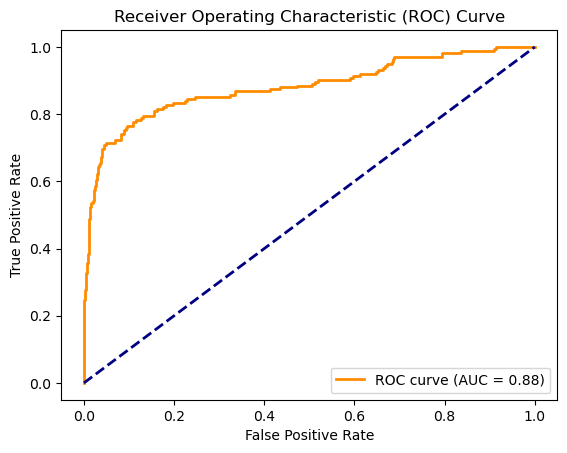

In [9]:
# Compute AUC-ROC and plot the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()